89.0
Image shape: (182, 218, 182)
(7221032,)


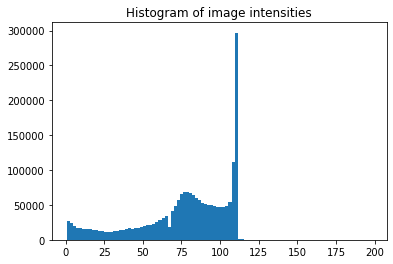

In [1]:
import nibabel as nib
import numpy as np
import tqdm as tqdm
import matplotlib.pyplot as plt

# Load the NIfTI image
nifti_image = nib.load('OneDrive_2025-03-09/SMAI Assignment 2/sald_031764_img.nii')

# Get the image data as a numpy array
image_data = nifti_image.get_fdata()
print(image_data[100, 90, 47])

# Get the shape of the image (this gives the 3D dimensions of the voxel grid)
shape = image_data.shape
print(f"Image shape: {shape}")
print(image_data.flatten().shape)

# flatten the image data and plot the histogram, ignore the zero values
plt.hist(image_data.flatten()[image_data.flatten() != 0], bins=100)
plt.title("Histogram of image intensities")
plt.show()



In [2]:
def gaussian_pdf(x,mu,sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-mu)/sigma)**2)

In [3]:
import numpy as np
from sklearn.cluster import KMeans
import tqdm

# Gaussian PDF function
def gaussian_pdf(x, mean, variance):
    eps = 1e-6  # to prevent division by zero
    return (1.0 / np.sqrt(2.0 * np.pi * (variance + eps))) * np.exp(-0.5 * (x - mean)**2 / (variance + eps))

class GMM:
    def __init__(self, image_data, n_components=3):
        self.image_data = image_data
        self.image_shape = image_data.shape
        self.flattened_image_with_zero = image_data.flatten()
        # ignore the zero voxels in the image data
        self.flattened_image = self.flattened_image_with_zero[self.flattened_image_with_zero > 0]
        self.n_components = n_components


        kmeans = KMeans(n_clusters=n_components, random_state=0).fit(self.flattened_image.reshape(-1, 1))
        
        self.means = kmeans.cluster_centers_.flatten()
        self.variances = np.array([np.var(self.flattened_image[kmeans.labels_ == i]) for i in range(n_components)])
        self.weights = np.array([np.sum(kmeans.labels_ == i) / self.flattened_image.shape[0] for i in range(n_components)])
        self.responsibilities = np.zeros((self.flattened_image.shape[0], n_components))


    def likelihoods(self):
        likelihoods = np.zeros((self.flattened_image.shape[0], self.n_components))
        
        for i in range(self.n_components):
            likelihoods[:, i] = gaussian_pdf(self.flattened_image, self.means[i], self.variances[i])
            
        return likelihoods


    def expectation(self):
        likelihoods = self.likelihoods()
        for i in range(self.n_components):
            self.responsibilities[:, i] = self.weights[i] * likelihoods[:, i]
        self.responsibilities /= (np.sum(self.responsibilities, axis=1, keepdims=True) + 1e-6)  # Normalize responsibilities


    def maximization(self):
        for i in range(self.n_components):
            responsibility_sum = np.sum(self.responsibilities[:, i])
            self.means[i] = np.sum(self.responsibilities[:, i] * self.flattened_image) / responsibility_sum
            self.variances[i] = np.sum(self.responsibilities[:, i] * (self.flattened_image - self.means[i])**2) / responsibility_sum
            self.weights[i] = responsibility_sum / self.flattened_image.shape[0]

    def train(self, iter=10):
        for i in tqdm.tqdm(range(iter)):
            self.expectation()
            self.maximization()


brain_segmenter = GMM(image_data, n_components=3)
brain_segmenter.train(iter=10)


/home/akshara/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


In [6]:
# brain_segmenter = GMM(image_data,n_components=3)
# brain_segmenter.train()
print(brain_segmenter.means)
print(brain_segmenter.variances)
print(brain_segmenter.weights)
segmented_image = np.zeros(brain_segmenter.flattened_image_with_zero.shape[0])
non_zero_mask = brain_segmenter.flattened_image_with_zero > 0
for i in range(brain_segmenter.n_components):
    segmented_image[non_zero_mask] += brain_segmenter.responsibilities[:,i]*brain_segmenter.means[i]
segmented_image = segmented_image.reshape(brain_segmenter.image_shape)
# plt.imshow(segmented_image[:,:,100],cmap='gray')
# plt.show()

[ 79.7977237   26.21088402 107.90559213]
[182.69094543 310.9267448    9.78657283]
[0.54437043 0.19277634 0.26236302]


In [7]:
segmented_nifti = nib.Nifti1Image(segmented_image, nifti_image.affine)
nib.save(segmented_nifti, 'segmented_image')

In [15]:
# load the probability masks for the 3 labels
csf_nifti_image = nib.load('OneDrive_2025-03-09/SMAI Assignment 2/sald_031764_probmask_csf.nii')
gm_nifti_image = nib.load('OneDrive_2025-03-09/SMAI Assignment 2/sald_031764_probmask_graymatter.nii')
wm_nifti_image = nib.load('OneDrive_2025-03-09/SMAI Assignment 2/sald_031764_probmask_whitematter.nii')

csf_image = csf_nifti_image.get_fdata()
gm_image = gm_nifti_image.get_fdata()
wm_image = wm_nifti_image.get_fdata()

# calculate the accuracy of the segmentation
correct = 0
total = 0

predicted_labels = np.zeros(brain_segmenter.flattened_image_with_zero.shape[0], dtype=int)

predicted_labels[non_zero_mask] = np.argmax(brain_segmenter.responsibilities, axis=1)
predicted_labels = predicted_labels.reshape(brain_segmenter.image_shape)

csf_mask = (csf_image >= 0.5) 
gm_mask = (gm_image >= 0.5)
wm_mask = (wm_image >= 0.5)
zero_mask = ~(csf_mask | gm_mask | wm_mask)

predicted_labels[zero_mask] = 0 

ground_truth_labels = np.zeros(brain_segmenter.image_shape)
ground_truth_labels[gm_mask] = 1  # GM is label 1
ground_truth_labels[wm_mask] = 2  # WM is label 2

# Only compare voxels where we have a ground truth label
valid_voxels = (csf_mask | gm_mask | wm_mask | zero_mask)

predicted_labels_valid = predicted_labels[valid_voxels]
ground_truth_labels_valid = ground_truth_labels[valid_voxels]

# Calculate the accuracy
correct_voxels_count = np.sum(predicted_labels_valid == ground_truth_labels_valid)
total_voxels = len(predicted_labels_valid)  # Total number of voxels with valid ground truth labels

accuracy = correct_voxels_count / total_voxels
print(f"Accuracy: {accuracy}")

            

Accuracy: 0.793913944710396


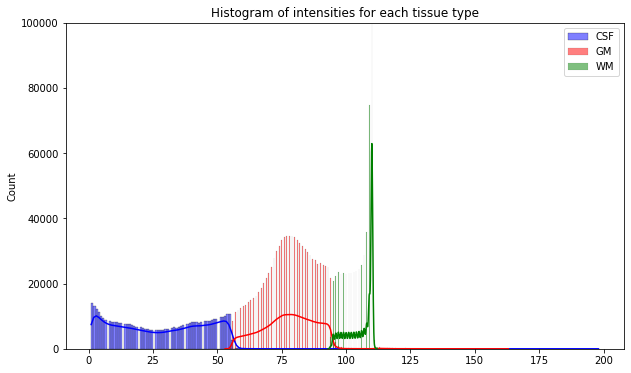

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# plot the frequency of intensities for each label
plt.figure(figsize=(10, 6))
sns.histplot(image_data[csf_mask], color='blue', label='CSF', kde=True)
sns.histplot(image_data[gm_mask], color='red', label='GM', kde=True)
sns.histplot(image_data[wm_mask], color='green', label='WM', kde=True)
plt.title('Histogram of intensities for each tissue type')
plt.ylim(0, 100000)
plt.legend()
plt.show()



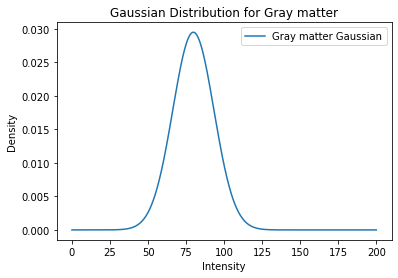

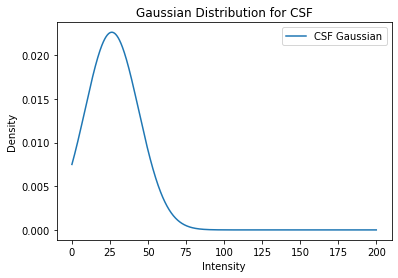

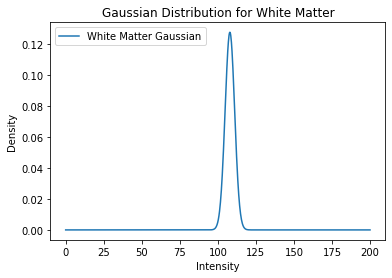

In [18]:
# plot the each gaussians separately in different graphs
def plot_gaussian(mean, variance, weight, tissue_name):
    x = np.linspace(0, 200, 1000)
    y = gaussian_pdf(x, mean, variance)
    plt.plot(x, y, label=f'{tissue_name} Gaussian')
    plt.xlabel('Intensity')
    plt.ylabel('Density')
    plt.legend()
    plt.title(f'Gaussian Distribution for {tissue_name}')
    plt.show()

plot_gaussian(brain_segmenter.means[0], brain_segmenter.variances[0], brain_segmenter.weights[0], 'Gray matter')
plot_gaussian(brain_segmenter.means[1], brain_segmenter.variances[1], brain_segmenter.weights[1], 'CSF')
plot_gaussian(brain_segmenter.means[2], brain_segmenter.variances[2], brain_segmenter.weights[2], 'White Matter')


gray matter (GM) occupies a fairly broad range of intensities—much wider than either white matter (WM) or CSF. As a result, the tails of the GM distribution overlap significantly with the adjacent WM and/or CSF peaks. This overlap region is where the GMM will tend to make the most mistakes because voxels with intensities in that boundary zone can be assigned (with non-negligible probability) to more than one class.